# DC GAN(Deep Convolutional GAN)

In [1]:
import warnings
warnings.filterwarnings('ignore')

> ## Import Packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense, LeakyReLU, Dropout, Input, BatchNormalization
from tensorflow.keras.layers import Reshape, Conv2D, Conv2DTranspose, Flatten, Activation
from tensorflow.keras.models import Model,Sequential

# I. Load MNIST Dataset

* 'generator'의 'tanh' Activation 출력에 적합하도록 정규화

In [3]:
from tensorflow.keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()
    
# Normalization
X_train = X_train.astype(np.float32) / 127.5 - 1
    
# Reshape
X_train = X_train.reshape(-1, 28, 28, 1)

11501568/11490434 [==============================] - 0s 0us/step


# II. 'adam' Optimizer

* beta_1 : 감쇠율 조정

In [4]:
from tensorflow.keras.optimizers import Adam

adam = Adam(lr = 0.0002, beta_1 = 0.5)

# III. 'generator' Model

* 랜덤 벡터(잠재공간의 랜덤 포인트)를 입력받아 이미지 생성
 - NOISE_DIM : 입력 랜덤 벡터 크기
* 'discriminator'를 속이도록 학습
 - 'Real Image'와 같은 'Fake Image' 생성이 목적

In [5]:
NOISE_DIM = 10

generator = Sequential(name = 'generator')

generator.add(Dense(256 * 7 * 7, input_shape = (NOISE_DIM,)))
generator.add(LeakyReLU())
# 12544
generator.add(Reshape((7, 7, 256)))
# (14, 14, 128) 25088
generator.add(Conv2DTranspose(128, kernel_size = 3, 
                              strides = 2, 
                              padding = 'same'))
generator.add(BatchNormalization())
generator.add(LeakyReLU())
# (28, 28, 64) 50176
generator.add(Conv2DTranspose(64, kernel_size = 3, 
                              strides = 2, 
                              padding = 'same'))
generator.add(BatchNormalization())
generator.add(LeakyReLU())
# (28, 28, 1)
generator.add(Conv2D(1, kernel_size = 3, padding='same'))
generator.add(Activation('tanh'))

* Model Summary

In [6]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             137984    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      295040    
 nspose)                                                         
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 128)      512       
 ormalization)                                                   
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0 

# IV. 'discriminator' Model

* 이미지를 입력받아 'Real Image'인지 'generator'가 생성한 'Fake Image' 인지 판별
 - 이진분류

In [7]:
from tensorflow.keras.initializers import RandomNormal

discriminator = Sequential(name = 'discriminator')

discriminator.add(Conv2D(32, kernel_size = 3, 
                         strides = 2, 
                         padding = 'same', 
                         input_shape = (28, 28, 1)))
discriminator.add(LeakyReLU())
discriminator.add(Dropout(0.5))
discriminator.add(Conv2D(64, kernel_size = 3, 
                         strides = 2, 
                         padding = 'same'))
discriminator.add(LeakyReLU())
discriminator.add(Conv2D(128, kernel_size = 3, 
                         strides = 2, 
                         padding = 'same'))
discriminator.add(LeakyReLU())
discriminator.add(Dropout(0.5))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation = 'sigmoid'))

* Model Summary

In [8]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        320       
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 32)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 64)          0         
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 4, 4, 128)       

> ## 1) 'discriminator' Compile

* 학습 설정

In [9]:
discriminator.compile(loss = 'binary_crossentropy',
                      optimizer = adam)

# V. 'gan' Model

> ## 1) 'generator', 'discriminator' 연결

* 'gan' 모델에서 'generator'만 학습하도록 설정
 - discriminator.trainable = False

In [10]:
discriminator.trainable = False

gan_input = Input(shape = (NOISE_DIM,))
x = generator(gan_input)
output = discriminator(x)

> ## 2) 'gan' Model

In [11]:
gan = Model(gan_input, output, name = 'gan')

> ## 3) 'gan' Summary

In [12]:
gan.summary()

Model: "gan"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10)]              0         
                                                                 
 generator (Sequential)      (None, 28, 28, 1)         508161    
                                                                 
 discriminator (Sequential)  (None, 1)                 94721     
                                                                 
Total params: 602,882
Trainable params: 507,777
Non-trainable params: 95,105
_________________________________________________________________


> ## 4) 'gan' Compile

* 학습 설정

In [13]:
gan.compile(loss = 'binary_crossentropy', 
            optimizer = adam)

# VI. Define 'get_batches( )' Function

* MNIST image batch 생성

In [14]:
def get_batches(data, batch_size):
    batches = []

    for i in range(data.shape[0] // batch_size):
        batch = data[i * batch_size : (i + 1) * batch_size]
        batches.append(batch)
    return np.asarray(batches)

# VII. 'visualize_training( )' Function

In [15]:
def visualize_training(epoch, d_losses, g_losses):

    # 오차 시각화
    # plt.figure(figsize=(8, 4))
    # plt.plot(d_losses, label='Discriminator Loss')
    # plt.plot(g_losses, label='Generatror Loss')
    # plt.xlabel('Epoch')
    # plt.ylabel('Loss')
    # plt.legend()
    # plt.show()
    # print('epoch: {}, Discriminator Loss: {}, Generator Loss: {}'.format(epoch, np.asarray(d_losses).mean(), np.asarray(g_losses).mean()))
    
    # 이미지 생성 결과 시각화
    print('epoch :', epoch)
    noise = np.random.normal(0, 1, size = (24, NOISE_DIM))
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(-1, 28, 28)
    
    plt.figure(figsize = (8, 4))
    for i in range(generated_images.shape[0]):
        plt.subplot(4, 6, i + 1)
        plt.imshow(generated_images[i], interpolation = 'nearest', cmap = 'Greys_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# VIII. Define Loss

In [16]:
# loss_function = keras.losses.BinaryCrossentropy()

# train_loss = keras.metrics.BinaryCrossentropy(name = 'train_loss')
# train_accuracy = keras.metrics.BinaryAccuracy(name = 'train_accuracy')

# IX. Model Training

* 약 60분
<br>
<br>
* .fit( )
 - 'epoch', 'batch_size' 지정
* .train_on_batch( )
 - 전달 받은 모든 데이터를 사용하여 학습 진행
* 'generator'가 매번 새로운 'Fake Image'를 생성하여 '.train_on_batch( )' 사용

epoch : 1


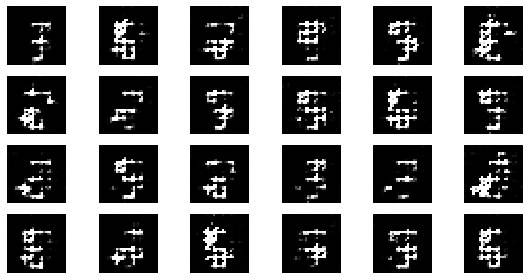

epoch : 5


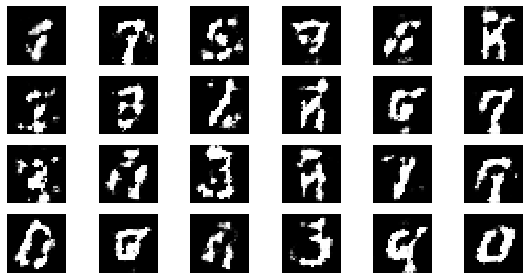

epoch : 10


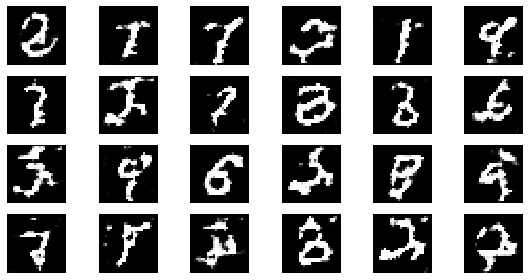

epoch : 15


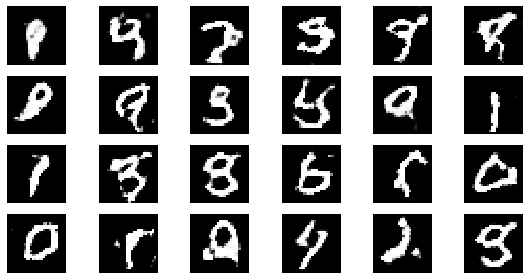

epoch : 20


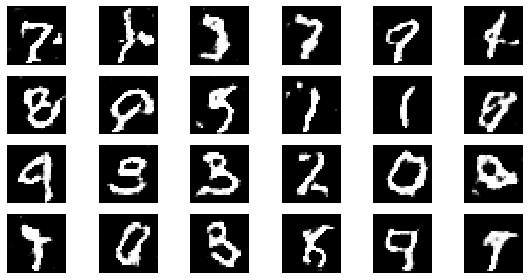

epoch : 25


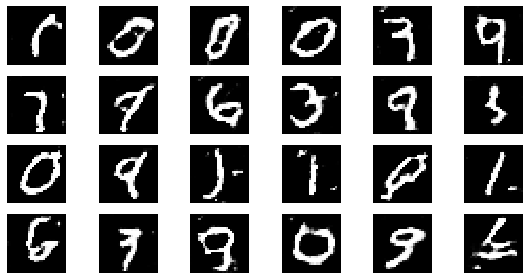

epoch : 30


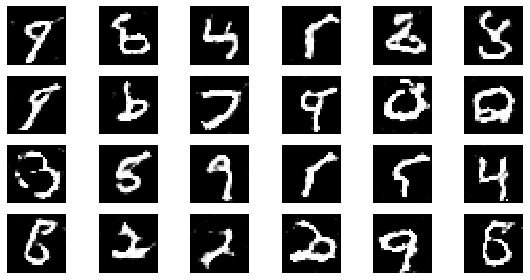

epoch : 35


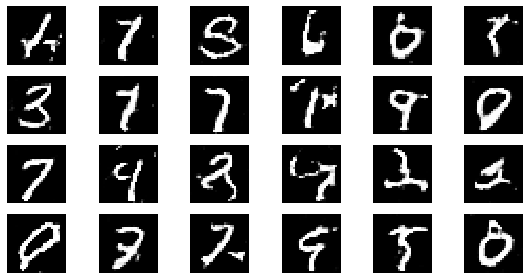

epoch : 40


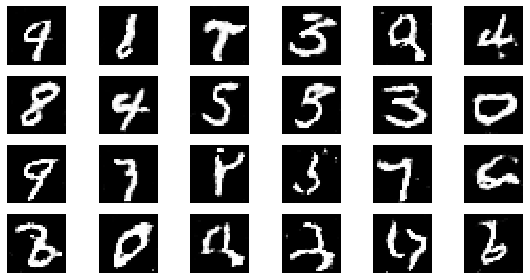

epoch : 45


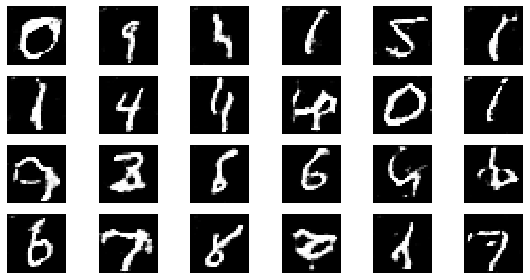

epoch : 50


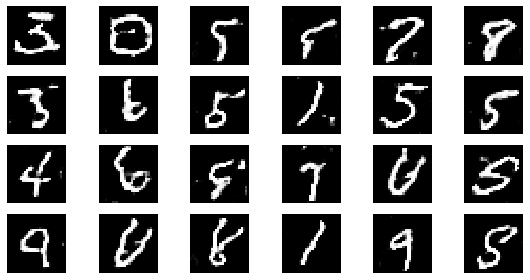

CPU times: user 50min 31s, sys: 1min 58s, total: 52min 30s
Wall time: 54min 48s


In [17]:
%%time

EPOCHS = 50
BATCH_SIZE = 128

# 'discriminator', 'gan' Loss 저장 List
d_losses = []
g_losses = []

for epoch in range(1, EPOCHS + 1):
    # batch 별 학습
    for real_images in get_batches(X_train, BATCH_SIZE):
        # Random Noise 생성
        input_noise = np.random.uniform(-1, 1, size = [BATCH_SIZE, NOISE_DIM])
        
        # Fake Image 데이터 생성
        generated_images = generator.predict(input_noise)
        
        # 'gan' 학습용 X 데이터 정의
        x_dis = np.concatenate([real_images, generated_images])
        
        # 'gan' 학습용 y 데이터 정의
        y_dis = np.zeros(2 * BATCH_SIZE)
        y_dis[:BATCH_SIZE] = 1
        
        # 'discriminator' 학습
        discriminator.trainable = True
        d_loss = discriminator.train_on_batch(x_dis, y_dis)
        
        # 'gan' 학습
        noise = np.random.uniform(-1, 1, size = [BATCH_SIZE, NOISE_DIM])
        y_gan = np.ones(BATCH_SIZE)
        
        # 'discriminator' 학습 정지
        discriminator.trainable = False
        g_loss = gan.train_on_batch(noise, y_gan)
        
    d_losses.append(d_loss)
    g_losses.append(g_loss)

    # 생성 결과 시각화
    if epoch == 1 or epoch % 5 == 0:
        visualize_training(epoch, d_losses, g_losses)

# 
# 
# 
# The End
# 
# 
# 